## Plotting and Analyzing Learned Parameters of Trained BINN
#### Uses BINNCovasim Neural Network Model

In [1]:
import sys
sys.path.append('../')

from Modules.Utils.Imports import *
from Modules.Models.BuildBINNs import BINNCovasim
from Modules.Utils.ModelWrapper import ModelWrapper

import Modules.Utils.PDESolver as PDESolver
import Modules.Loaders.DataFormatter as DF
from utils import get_case_name, lasso_parameter_fitting
import seaborn as sns
# sns.set(font_scale=1.2, style='white')
from sklearn import linear_model

c:\Users\Teddy\anaconda3\envs\reu_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device(GetLowestGPU(pick_from=[0,1,2,3]))
# helper functions
def to_torch(x):
    return torch.from_numpy(x).float().to(device)
def to_numpy(x):
    return x.detach().cpu().numpy()

Device set to cpu


In [3]:
# instantiate BINN model parameters and path
path = '../Data/covasim_data/drums_data/'
# path = '../Data/covasim_data/xin_data/'

population = int(200e3)
test_prob = 0.1
trace_prob = 0.3
keep_d = True
retrain = False
dynamic = True
masking = 0
multiple = True
parallelb = True
n_runs = 1024
chi_type = 'piecewise'

case_name = get_case_name(population, test_prob, trace_prob, keep_d, dynamic=dynamic, chi_type=chi_type)
# yita_lb, yita_ub = 0.2, 0.4

In [4]:
if not masking==0:
    if masking==1:
        case_name = case_name + '_maskingthresh'
    elif masking==2:
        case_name = case_name + '_maskinguni'
    elif masking==3:
        case_name = case_name + '_maskingnorm'

if multiple:
    params = DF.load_covasim_data(path, population, test_prob, trace_prob, keep_d, case_name + '_' + str(n_runs), plot=False)
else:
    params = DF.load_covasim_data(path, population, test_prob, trace_prob, keep_d, case_name, plot=False)

In [5]:
# split into train/val and convert to torch
# multiple==True and parallelb==False means that data is a list and not normalized
if multiple and not parallelb:
    data = np.mean(params['data'], axis=0)
    data = (data / params['population'])
# multiple==True and parallelb==True means that the data is a 2d array and normalized
elif multiple and parallelb:
    data = params['data']
# otherwise, the data is from a single simulation and is not normalized
else:
    data = params['data']
    data = (data / params['population']).to_numpy()
    
params.pop('data')

N = len(data)
t_max = N - 1
t = np.arange(N)

split = int(0.8*N)
p = np.random.permutation(N)

x_train = to_torch(p[:split][:, None]/(N-1))
y_train = to_torch(data[p[:split]])
x_val = to_torch(p[split:][:, None]/(N-1))
y_val = to_torch(data[p[split:]])

tracing_array = params['tracing_array']

In [6]:
mydir = '../models/covasim/2023-07-12_11-00-45' # no masking, 200e3 pop, dynamic piecewise, keepd, 1024 avg., 50e3 epochs, lr=1e4

In [7]:
binn = BINNCovasim(params, t_max, tracing_array, keep_d=keep_d).to(device)
parameters = binn.parameters()
model = ModelWrapper(binn, None, None, save_name=os.path.join(mydir, case_name))

In [8]:
# load model weights
# model.save_name = '../Weights/'
# model.save_name += case_name
if retrain:
    model.save_name += '_retrain'
model.save_name += '_best_val'
model.load(model.save_name + '_model', device=device)
save_path = model.save_folder
# grab initial condition
u0 = data[0, :].copy()

In [9]:
# if not folder for plots exists, make them
if not os.path.exists(model.save_folder + '\\eta_plots'):
    os.makedirs(os.path.join(model.save_folder, 'eta_plots'))
    os.makedirs(os.path.join(model.save_folder, 'beta_plot'))
    os.makedirs(os.path.join(model.save_folder, 'tau_plot'))
    os.makedirs(os.path.join(model.save_folder, 'lasso_plots'))

In [10]:
# grab value ranges
yita_lb, yita_ub = model.model.yita_lb, model.model.yita_ub
beta_lb, beta_ub = model.model.beta_lb, model.model.beta_ub
tau_lb, tau_ub = model.model.tau_lb, model.model.tau_ub

In [11]:
# learned contact_rate function
def contact_rate(u):
    res = binn.eta_func(to_torch(u)) # [:,[0,3,4]]
    return to_numpy(res)
# learned tracing rate function
def beta(u):
    res = binn.beta_func(to_torch(u))
    return to_numpy(res)
# learned diagnoses rate of quarantined individuals
def tau(u):
    res = binn.tau_func(to_torch(u))
    return to_numpy(res)

In [16]:
#%% visualization for eta
s_min, s_max = data[:,0].min(), data[:,0].max()
a_min, a_max = data[:,3].min(), data[:,3].max()
y_min, y_max = data[:,4].min(), data[:,4].max()
say_min, say_max = (data[:,0] + data[:,3] + data[:,4]).min(), (data[:,0] + data[:,3] + data[:,4]).max()
chi_min, chi_max = 0.0, params['eff_ub']

0.39270878
0.412598
0.25379834


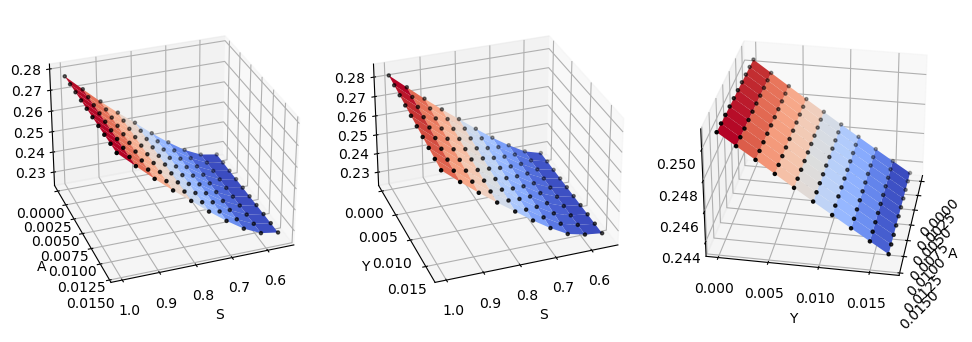

In [17]:
# grid for inputs S, A
a_grid = np.linspace(s_min, s_max, 10)
# grid for inputs S, Y
b_grid = np.linspace(a_min, a_max, 10)
# grid for inputs A, Y
c_grid = np.linspace(y_min, y_max, 10)

labels = ['S', 'A', 'Y']
fig = plt.figure(figsize=(10,7))
# for each of the 3 input combinations
for i in range(3):
    if i == 0:
        X, Y = np.meshgrid(a_grid, b_grid)
        Z = np.ones_like(X) * c_grid.mean()
        # set x and y labels to S and A
        x_label, y_label = labels[0], labels[1]
    elif i == 1:
        X, Z = np.meshgrid(a_grid, c_grid)
        Y = np.ones_like(X) * b_grid.mean()
        # set x and y labels to S and Y
        x_label, y_label = labels[0], labels[2]
    else:
        Y, Z = np.meshgrid(b_grid, c_grid)
        X = np.ones_like(Y) * a_grid.mean()
        # set x and y labels to A and Y
        x_label, y_label = labels[1], labels[2]

    # grid of S, A, Y values
    u_grid = np.stack([np.ravel(X), np.ravel(Y), np.ravel(Z)], axis=1)
    # result of evaluating eta with inputs S, A, Y
    res = contact_rate(u_grid)
    # transfom eta(S, A, Y) into the interval previously defined
    res = yita_lb + (yita_ub - yita_lb) * res
    res = res[:,0].reshape(X.shape)
    res = np.round(res, decimals=6)
    
    ax = fig.add_subplot(1, 3, i + 1, projection='3d')
    if i == 0:
        ax.plot_surface(X, Y, res, cmap=cm.coolwarm, alpha=1)
        ax.scatter(X.reshape(-1), Y.reshape(-1), res.reshape(-1), s=5, c='k')
        ax.view_init(30,70)
    elif i == 1:
        ax.plot_surface(X, Z, res, cmap=cm.coolwarm, alpha=1)
        ax.scatter(X.reshape(-1), Z.reshape(-1), res.reshape(-1), s=5, c='k')
        ax.view_init(30,70)
    else:
        ax.plot_surface(Y, Z, res, cmap=cm.coolwarm, alpha=1)
        ax.scatter(Y.reshape(-1), Z.reshape(-1), res.reshape(-1), s=5, c='k')
        plt.setp(ax.get_xticklabels(), rotation=45) # , ha="right", rotation_mode="anchor"
        ax.view_init(30,10)

    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    
plt.tight_layout(pad=2)
plt.savefig(os.path.join(save_path + '\\eta_plots', case_name + '_parameter_NN_eta_DRUMS' + '.png'), dpi=300, bbox_inches='tight')
plt.show()
plt.close()

C:\Users\Teddy\AppData\Local\Temp\ipykernel_1032\2795833017.py:25: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout(pad=2)


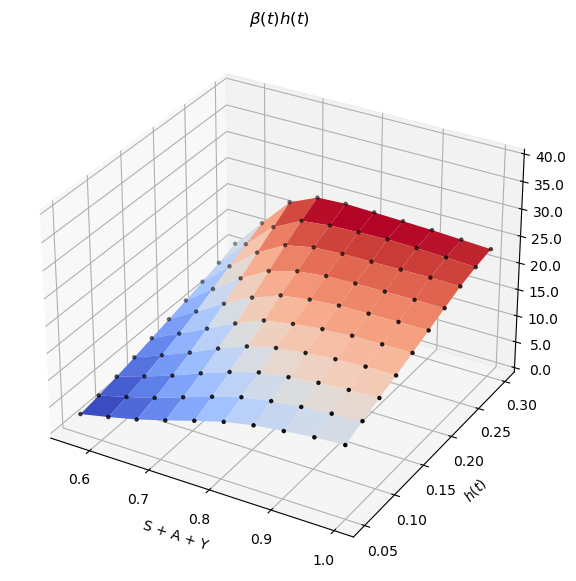

In [30]:
#%% visualization for beta
chi_min, chi_max = 0.05, params['eff_ub']
# chi_grid = np.linspace(chi_min, chi_max, 10)

a_grid = np.linspace(say_min, say_max, 10) # S + A + Y
b_grid = np.linspace(chi_min, chi_max, 10)
labels = ['S + A + Y', r'$h(t)$']

X, Y = np.meshgrid(a_grid, b_grid)
x_label, y_label = labels[0], labels[1]
u_grid = np.stack([np.ravel(X), np.ravel(Y)], axis=1)
res = beta(u_grid) * params['n_contacts'] # * u_grid[:, [1]] *
res = res[:,0].reshape(X.shape)
res = np.round(res, decimals=6)
# res = beta_lb + (beta_ub - beta_lb) * res

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.plot_surface(X, Y, res, cmap=cm.coolwarm, alpha=1)
ax.scatter(X.reshape(-1), Y.reshape(-1), res.reshape(-1), s=5, c='k')
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
ax.set_zticks(np.arange(0,40.1, 5), np.arange(0,40.1, 5))
ax.set_title(r'$\beta(t)h(t)$')
plt.tight_layout(pad=2)

plt.savefig(os.path.join(save_path + '\\beta_plot', case_name + '_parameter_NN_beta_DRUMS' + '.png'), dpi=300, bbox_inches='tight' )
plt.show()
plt.close()

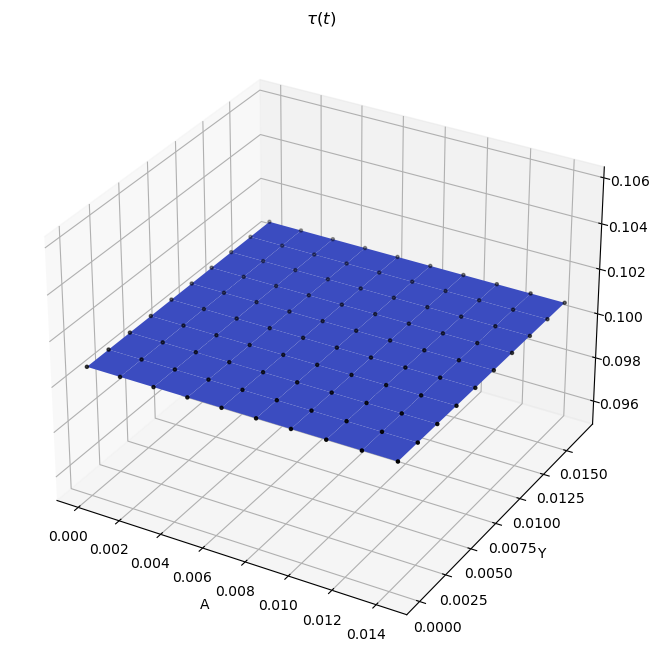

In [31]:
#%% visualization for tau

a_grid = np.linspace(a_min, a_max, 10)
b_grid = np.linspace(y_min, y_max, 10)
labels = ['A', 'Y']

X, Y = np.meshgrid(a_grid, b_grid)
x_label, y_label = labels[0], labels[1]
u_grid = np.stack([np.ravel(X), np.ravel(Y)], axis=1)
res = tau(u_grid)
res = res[:,0].reshape(X.shape)
res = tau_lb + (tau_ub - tau_lb) * res # scaling
res = np.round(res, decimals=4)

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.plot_surface(X, Y, res, cmap=cm.coolwarm, alpha=1)
ax.scatter(X.reshape(-1), Y.reshape(-1), res.reshape(-1), s=5, c='k')
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
ax.set_title(r'$\tau(t)$')
plt.tight_layout(pad=2)
plt.savefig(os.path.join(save_path + '\\tau_plot', case_name + '_parameter_NN_tau_DRUMS' + '.png'), dpi=300, bbox_inches='tight')
plt.show()
plt.close()


In [32]:
# lasso regression to learn symbolic terms from parameter NN
def get_samples_ct(u):
    s, a, y =  u[:, 0][:, None], u[:, 1][:, None], u[:, 2][:, None]
    candidates = [s, s**2, a, y] # s related terms
    # candidates += [a]
    # candidates += [y]
    # candidates += [chi]
    candidates = np.concatenate(candidates, axis=1)
    return candidates

def get_samples_beta(u):
    drf, chi = u[:, 0][:, None], u[:, 1][:, None]
    candidates = [drf, chi] # , chi**2
    candidates = np.concatenate(candidates, axis=1)
    return candidates

def get_samples_tau(u):
    a, y = u[:, 0][:, None], u[:, 1][:, None]
    candidates = [a, y]
    candidates = np.concatenate(candidates, axis=1)
    return candidates

s_grid = np.linspace(s_min, s_max, 10)
a_grid = np.linspace(a_min, a_max, 10)
y_grid = np.linspace(y_min, y_max, 10)
train_x = np.array(np.meshgrid(s_grid, a_grid, y_grid)).T.reshape(-1,3)
data_x = get_samples_ct(train_x)
data_y = contact_rate(train_x)
data_y = data_y[:,0][:, None]
# data_y = yita_lb + (yita_ub - yita_lb) * data_y

term_names = ['S', 'S^2', 'A', 'Y'] #
lasso_parameter_fitting(data_x, data_y, 'eta', save_path + '\\lasso_plots', case_name, True, term_names)


a_grid = np.linspace(0.6, 1.0, 10) # D + R + F
b_grid = np.linspace(chi_min, chi_max, 10)
term_names = ['S + A + Y', r'$\chi$']
# c_grid = np.ones_like(a_grid) * chi_max
train_x = np.array(np.meshgrid(a_grid, b_grid)).T.reshape(-1,2)
data_x = get_samples_beta(train_x)
data_y = beta(train_x)
data_y = data_y[:,0][:, None]
lasso_parameter_fitting(data_x[:, :], data_y, 'beta', save_path + '\\lasso_plots', case_name, True, term_names)

a_grid = np.linspace(a_min, a_max, 10)
b_grid = np.linspace(y_min, y_max, 10)
term_names = ['A', 'Y']
# c_grid = np.ones_like(a_grid) * chi_max
train_x = np.array(np.meshgrid(a_grid, b_grid)).T.reshape(-1,2)
data_x = get_samples_tau(train_x)
data_y = tau(train_x)
data_y = data_y[:,0][:, None]
# data_y = tau_lb + (tau_ub - tau_lb) * data_y
lasso_parameter_fitting(data_x[:, :], data_y, 'tau', save_path + '\\lasso_plots', case_name, True, term_names)

c:\Users\Teddy\anaconda3\envs\reu_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1561: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Computing regularization path using the lasso...


c:\Users\Teddy\anaconda3\envs\reu_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1561: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Computing regularization path using the lasso...


c:\Users\Teddy\anaconda3\envs\reu_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1561: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Computing regularization path using the lasso...


***Code Below not Operational - 06/24/2023***

In [47]:
from sklearn.linear_model import MultiTaskLassoCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

start_time = time.time()
model = make_pipeline( MultiTaskLassoCV(alphas=np.logspace(-6, -2), cv=5, max_iter=10000, fit_intercept=False)).fit(x_train, y_train)
fit_time = time.time() - start_time
ymin, ymax = 0, 1
lasso = model[-1]
plt.figure()
plt.semilogx(lasso.alphas_, lasso.mse_path_, linestyle=":")
plt.plot(
    lasso.alphas_,
    lasso.mse_path_.mean(axis=-1),
    color="black",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(lasso.alpha_, linestyle="--", color="black", label="alpha: CV estimate")

plt.ylim(ymin, ymax)
plt.xlabel(r"$\alpha$")
plt.ylabel("Mean square error")
plt.legend()
_ = plt.title(
    f"Mean square error on each fold: coordinate descent (train time: {fit_time:.2f}s)"
)
plt.savefig(save_path + case_name + '_lassoCV' + '.png')
plt.close()

In [42]:
from sklearn.linear_model import lasso_path
from itertools import cycle
# # Compute paths

eps = 5e-3  # the smaller it is the longer is the path

print("Computing regularization path using the lasso...")
alphas_lasso, coefs_lasso, _ = lasso_path(x_train, y_train.reshape(-1), alphas=np.logspace(-6, -2),max_iter=10000, eps=eps)
plt.figure()
colors = cycle(["b", "r", "g", "c"])
names = ['S', r'$S^2$', 'A', 'Y']
neg_log_alphas_lasso = alphas_lasso # -np.log10(alphas_lasso)
for coef_l, c, name in zip(coefs_lasso, colors, names):
    l1 = plt.semilogx(neg_log_alphas_lasso, coef_l, c=c, label=name)
plt.axvline(lasso.alpha_, linestyle="--", color="black", label="alpha: CV estimate")
plt.xlabel(r"$\alpha$")
plt.ylabel("coefficients")
plt.title("Lasso Paths")
plt.legend(loc="lower left")
plt.axis("tight")
plt.savefig(save_path + case_name + '_lassoPath' + '.png')
plt.close()
#
final_lasso = linear_model.Lasso(alpha=lasso.alpha_, max_iter=10000, fit_intercept=False)
final_lasso.fit(x_train, y_train)
final_lasso.coef_
pd.DataFrame(final_lasso.coef_).to_csv(save_path + case_name + '_regression_coef.csv')

fig = plt.figure(figsize=(10,7))
for i in range(3):
    if i == 0:
        X, Y = np.meshgrid(s_grid, a_grid)
        Z = np.ones_like(X) * 0.0
        x_label, y_label = 'S', 'A'
    elif i == 1:
        X, Z = np.meshgrid(s_grid, y_grid)
        Y = np.ones_like(X) * 0.0
        x_label, y_label = 'S', 'Y'
    else:
        Y, Z = np.meshgrid(a_grid, y_grid)
        X = np.ones_like(Y) * 0.5
        x_label, y_label = 'A', 'Y'
    u_grid = np.stack([np.ravel(X), np.ravel(Y), np.ravel(Z)], axis=1)
    res_nn = contact_rate(u_grid)
    u_grid_lasso = np.stack([np.ravel(X), np.ravel(X)**2, np.ravel(Y), np.ravel(Z)], axis=1)
    res_lasso = final_lasso.predict(u_grid_lasso)
    res_lasso = res_lasso.reshape(X.shape)
    res_nn = res_nn[:,0].reshape(X.shape)
    ax = fig.add_subplot(1, 3, i + 1, projection='3d')
if i == 0:
    ax.plot_surface(X, Y, res_nn, cmap=cm.coolwarm, alpha=1)
    ax.scatter(X.reshape(-1), Y.reshape(-1), res_nn.reshape(-1), s=5, c='k')
    ax.plot_surface(X, Y, res_lasso, cmap=cm.coolwarm, alpha=1)
    ax.scatter(X.reshape(-1), Y.reshape(-1), res_lasso.reshape(-1), s=5, c='r')
elif i == 1:
    ax.plot_surface(X, Z, res_nn, cmap=cm.coolwarm, alpha=1)
    ax.scatter(X.reshape(-1), Z.reshape(-1), res_nn.reshape(-1), s=5, c='k')
    ax.scatter(X.reshape(-1), Z.reshape(-1), res_lasso.reshape(-1), s=5, c='r')
else:
    ax.plot_surface(Y, Z, res_nn, cmap=cm.coolwarm, alpha=1)
    ax.scatter(Y.reshape(-1), Z.reshape(-1), res_nn.reshape(-1), s=5, c='k')
    ax.scatter(Y.reshape(-1), Z.reshape(-1), res_lasso.reshape(-1), s=5, c='r')

ax.set_xlabel(x_label)
ax.set_ylabel(y_label)

fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
plt.tight_layout(pad=2)

Computing regularization path using the lasso...


ValueError: shapes (1,146) and (1314,) not aligned: 146 (dim 1) != 1314 (dim 0)